In [1]:
## 导入必要的包
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import ndimage

# 一种储存数据的形式
import h5py

# 用于处理图片
from PIL import  Image

# 使用绘图工具时直接讲图绘制在notebook而不是新启一个Window
%matplotlib inline

In [2]:
## 定义数据导入方式
def load_dataset():
    train_dataset = h5py.File('/Users/Kum/Desktop/Machine_Learning/project/YIQIXUE_AI/data/week1/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 得到训练集的特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 得到训练集的Labels

    test_dataset = h5py.File('/Users/Kum/Desktop/Machine_Learning/project/YIQIXUE_AI/data/week1/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 得到测试集的特征
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 得到测试机的Labels

    classes = np.array(test_dataset["list_classes"][:]) # 得到分类的枚举值
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
## 读取训练数据（都是像素点）
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
## 简单查看数据分布
print "一共有{}个训练集和{}个测试集!".format(len(train_set_x_orig), len(test_set_x_orig))
print "训练集的形状是这样的{}".format(train_set_x_orig.shape)

一共有209个训练集和50个测试集!
训练集的形状是这样的(209, 64, 64, 3)


y = [0], it's a 'non-cat' picture.


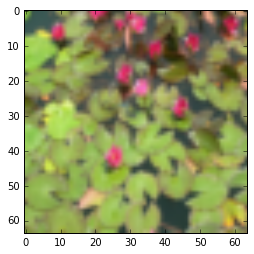

In [5]:
## 随便取出一个不是猫的像素点看看图片
index = 18
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


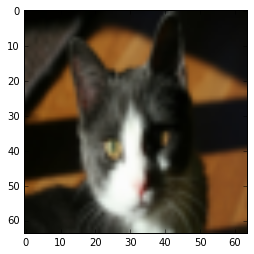

In [6]:
## 随便取出一个是猫的像素点看看图片
index = 19
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [7]:
## 分别取出训练集和测试并对整体数据进行一个观察
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("训练集的数量是: m_train = " + str(m_train))
print ("测试集的数量是: m_test = " + str(m_test))
print ("每一个图片的高和宽是: num_px = " + str(num_px))
print ("每一个图片的尺寸是: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练集的数量是: m_train = 209
测试集的数量是: m_test = 50
每一个图片的高和宽是: num_px = 64
每一个图片的尺寸是: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [8]:
## 将测试集和训练集的shape做转换，让其可以做训练，即flatten，其实就是num_px * num_px * 3（channel）
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [9]:
## 对像素做归一化处理,注意要是float格式
## 通常处理图片数据有三种常见操作
# 确定问题的维度、形状：多少个训练集、多少个测试集，像素是几乘几的
# 对数据集做处理，保证每一个样本数据是一个向量，向量的维度一定是(num_px * num_px * 3, 1)
# 对数据做归一化处理，即每个像素/255
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 接下来我们要手动实现下面几个公式 ##
对于单条数据： $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

然后计算损失函数：
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**遵循下面几个步骤搭建一个简单网络**:
1. 首先需要设计好模型的结构
2. 初始化所有模型的参数:
    - 可能全部用0初始化
    - 可能使用满足某种分布的初始化
3. 循环:
    - 计算当前的损失值（向前传播）
    - 计算当前的梯度（反向传播）
    - 更新参数（梯度下降）

In [10]:
## 定义Sigmoid函数
def sigmoid(z):
    """
    Sigmoid函数

    Arguments:
    x -- 一个实数或者任意长度的数组

    返回:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    
    return s

In [19]:
## 测试Sigmoid结果

print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(-9) = " + str(sigmoid(-9)))
print ("sigmoid(np.random.rand(6,6))" + str(sigmoid(np.random.rand(6,6))))

sigmoid(0) = 0.5
sigmoid(-9) = 0.000123394575986
sigmoid(np.random.rand(6,6))[[ 0.54674107  0.62060348  0.71771512  0.5956204   0.64628357  0.505212  ]
 [ 0.61231789  0.5935729   0.6886442   0.57617054  0.65336514  0.70301506]
 [ 0.68696069  0.66926523  0.53043376  0.51314882  0.52030703  0.66762332]
 [ 0.72636353  0.6826791   0.5003925   0.67847303  0.59062343  0.63145412]
 [ 0.67547505  0.53198938  0.52411973  0.6953685   0.68106173  0.5314193 ]
 [ 0.7264518   0.58640043  0.65476177  0.6941267   0.58963424  0.58386632]]


In [20]:
## 用0初始化参数

def initialize_with_zeros(dim):
    """
    该函数会返回一个shape为(dim,1),每一个元素都是0的向量作为w,并定义b为0
    
    Argument:
    dim -- 向量w的size(参数的个数)
    
    返回:
    w -- 初始化后shape为(dim, 1)的向量
    b -- 输出化后的实数(其实就是偏差)
    """
    
    w = np.zeros(shape=(dim, 1)) # 使用numpy生成所有元素为0的向量
    b = 0

    assert(w.shape == (dim, 1)) # 检查生成的向量w的shape是否和期望值一样
    assert(isinstance(b, float) or isinstance(b, int)) # 检查数据结构
    
    return w, b

In [21]:
## 测试初始化函数
dim = 6
w, b = initialize_with_zeros(dim)

print ("w = " + str(w))
print ("b = " + str(b))

w = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
b = 0


## 现在我们可以开始搭建神经网络 ##
#### 核心是通过"forward" 和 "backward"学习参数  ####

Forward Propagation:
- X 是我们的训练样本
- 我们需要计算: $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- 然后就可以计算损失函数: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

下面这个求导的公式我们后面也要用到: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [ ]:
# 向前传播

def propagate(w, b, X, Y):
    """
    计算损失函数和梯度值

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost